In [ ]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import time
import psutil
import io
import contextlib

import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.seasonal import STL

import shap
from windowshap import StationaryWindowSHAP

# Set seeds for reproducibility
np.random.seed(7) 
tf.random.set_seed(7) 

In [ ]:
### Step 0 : Setting (hyper)parameters and other variables

# Select the tickers and features to be used in the analysis
tickers_list = ['AAPL', 'GOOGL', 'MSFT', 'AMZN']
included_features = ['Open', 'Close', 'High', 'Low', 'Volume']

sample_start_date = '2020-05-01' # Extended dataset due to decomposition
sample_end_date = '2025-05-01'
n_window_size = 60

model_types = ['Standard', 'SHAP', 'WindowSHAP', 'Decomposed_WindowSHAP']
shap_tools = model_types[1:4]

# Setting color palette
color_palette = ['#211C84', '#4D55CC', '#7A73D1', '#B5A8D5']
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=color_palette)
sns.set_palette(color_palette)

# Setting folder paths for saving tables and figures
table_folder_path = '/Users/avril/Desktop/Thesis/Tables'
figure_folder_path = '/Users/avril/Desktop/Thesis/Figures'
os.makedirs(table_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)

# For robustness check
add_perturbation = False

In [ ]:
### Step 1 : Data preparation

data_per_ticker = {}

## Step 1.1 : Fetch data using Yahoo Finance
print("Downloading and storing data...")

def get_stock_data(ticker):
    df = yf.download(ticker, start=sample_start_date, end=sample_end_date, group_by='column')
    return df[included_features]

data_map = {ticker: get_stock_data(ticker) for ticker in tickers_list}

def add_gaussian_noise(df):
    df_copy = df.copy()

    noise_scale = 0.01 * df_copy.std()
    gaussian_noise = np.random.normal(loc=0, scale=noise_scale, size=df_copy.shape)
    df_perturbed = df_copy + gaussian_noise

    return df_perturbed
        
## Step 1.2 : Transform data into sequences for LSTM
print("Transforming data into sequences...")

class TickerData:
    '''
    Stores all the relevant data per ticker, namely:
    - df : the original dataframe from yfinance.
    - tran_df, test_df : an 80/20 split verion of df.
    - window_size = # of adjacent observations per sequence.
    - train_scaler, test_scaler = Separate MinMaxScalers to prevent data leakage.
    - X_train, X_test : scaled data of all price features and volume, in sequence format.
        - X_train_trend, X_train_seasonal, X_train_residual : Seasonally-decomposed version of X_train.
        - X_test_trend, X_test_seasonal, X_test_residual : Seasonally-decomposed version of X_test.
    - y_train, y_test : scaled data of the closing price.
    '''
    def __init__(self, df):
        
        if add_perturbation:
            df = add_gaussian_noise(df)
        self.df = df

        split_idx = int(len(df) * 0.8)
        train_df, test_df = df.iloc[:split_idx], df.iloc[split_idx:]

        self.window_size = n_window_size
        self.train_scaler, self.X_train, self.y_train = self.sequence_transform(train_df)
        self.test_scaler, self.X_test, self.y_test = self.sequence_transform(test_df)

        self.X_train_trend, self.X_train_seasonal, self.X_train_residual = None, None, None
        self.X_test_trend, self.X_test_seasonal, self.X_test_residual = None, None, None

    def build_sequences(self, df):
        X, y = [], []
        
        arr = df.values
        close_idx = df.columns.get_loc('Close')

        for i in range(len(df) - self.window_size):
            X.append(arr[i:i + self.window_size])
            y.append(arr[i + self.window_size, close_idx])
        
        return np.array(X), np.array(y)

    def sequence_transform(self, split_df):
        scaler = MinMaxScaler()
        scaler.fit(split_df)

        scaled_array = scaler.transform(split_df)
        scaled_df = pd.DataFrame(scaled_array, columns=split_df.columns, index=split_df.index)

        return scaler, self.build_sequences(scaled_df)

for ticker in tickers_list:
    df = data_map[ticker]
    data_per_ticker[ticker] = TickerData(df)

print('Number of data points:', len(data_per_ticker[tickers_list[0]].df))

## Step 1.3 : Decompose time series data
print("Decomposing time series data...")

def decompose_series(ts, period=21):
    stl_decomposition = STL(ts, period)
    return  stl_decomposition.fit() # returns trend, seasonal and residual components

def decompose_dataset(X):
    n_samples, _, n_features = X.shape
    trend_data, seasonal_data, resid_data = [np.zeros_like(X) for _ in range(3)]

    for i in range(n_samples):
        for j in range(n_features):
            ts = pd.Series(X[i, :, j])
            trend, seasonal, resid = decompose_series(ts)
            trend_data[i, :, j], seasonal_data[i, :, j], resid_data[i, :, j] = trend, seasonal, resid
    
    return trend_data, seasonal_data, resid_data

for ticker in tickers_list:
    X_train = data_per_ticker[ticker].X_train
    X_test = data_per_ticker[ticker].X_test
    X_background = X_train[:100]

    trend_train, seasonal_train, resid_train = decompose_dataset(X_train)
    trend_test, seasonal_test, resid_test = decompose_dataset(X_test)
    trend_background, seasonal_background, resid_background = decompose_dataset(X_background)

    data_per_ticker[ticker].X_train_trend = trend_train
    data_per_ticker[ticker].X_train_seasonal = seasonal_train
    data_per_ticker[ticker].X_train_residual = resid_train

    data_per_ticker[ticker].X_test_trend = trend_test
    data_per_ticker[ticker].X_test_seasonal = seasonal_test
    data_per_ticker[ticker].X_test_residual = resid_test

print("Data preparation complete.")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Transforming data into sequences...
Number of data points: 1256
Decomposing time series data...
Data preparation complete.


In [ ]:
## Step 1.3 : Generate summary statistics for each ticker
print("Generating summary statistics and plots...")

for ticker in tickers_list:
    df = data_map[ticker]

    stats = df.describe().round(3)
    stats.to_latex(f"{table_folder_path}/{ticker}_summary_stats.tex", 
               caption=f"Summary statistics for {ticker}",
               label=f"tab:{ticker.lower()}_summary",
               float_format="%.3f")

# Price plot for all tickers
plt.figure(figsize=(14, 6))

for ticker in tickers_list:
    df = data_map[ticker]
    if 'Close' in df.columns:
        plt.plot(df.index, df['Close'], label=f"{ticker} Close")

plt.title("Stock Close Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.savefig(f"{figure_folder_path}/all_tickers_prices.png")
plt.close()

# Volume plot for all tickers
plt.figure(figsize=(14, 4))

for ticker in tickers_list:
    df = data_map[ticker]
    if 'Volume' in df.columns:
        plt.plot(df.index, df['Volume'], label=f"{ticker} Volume")

plt.title("Stock Trading Volumes Over Time")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.legend()
plt.tight_layout()
plt.savefig(f"{figure_folder_path}/all_tickers_volumes.png")
plt.close()

Generating summary statistics and plots...


In [ ]:
### Step 2 : LSTM Training and Evaluation

model_per_ticker = {
    ticker: {} for ticker in tickers_list
}

def build_model(n_input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=n_input_shape))
    model.add(Dropout(0.2)) 
    model.add(LSTM(32)) 
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mse')
    return model

def gen_store_predictions(model, X_test, y_test, ticker):
    y_pred = model.predict(X_test, verbose=0)

    scaler = data_per_ticker[ticker].train_scaler
    close_idx = data_map[ticker].columns.get_loc('Close')

    # Reverse Min-Max scaling 
    dummy_pred = np.zeros((y_pred.shape[0], len(included_features)))
    dummy_pred[:, close_idx] = y_pred
    inv_y_pred = scaler.inverse_transform(dummy_pred)[:, close_idx]

    dummy_test = np.zeros((y_test.shape[0], len(included_features)))
    dummy_test[:, close_idx] = y_test
    inv_y_test = scaler.inverse_transform(dummy_test)[:, close_idx]

    return inv_y_pred, inv_y_test

def evaluate_predictions(inv_y_pred, inv_y_test):
    mae = np.mean(np.abs(inv_y_pred - inv_y_test))
    mse = mean_squared_error(inv_y_test, inv_y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((inv_y_test - inv_y_pred)/ inv_y_test)) * 100
    return mae, mse, rmse, mape

for ticker in tickers_list:
    print(f'\nTraining Standard model for {ticker}...')
    start_time = time.time()
    process = psutil.Process(os.getpid())
    start_ram = process.memory_info().rss / (1024 * 1024)

    ticker_data = data_per_ticker[ticker]
    X_train, y_train = ticker_data.X_train, ticker_data.y_train
    X_test, y_test = ticker_data.X_test, ticker_data.y_test

    model = build_model((ticker_data.window_size, X_train.shape[2]))
    model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0)

    inv_y_pred, inv_y_test = gen_store_predictions(model, X_test, y_test, ticker)
    mae, mse, rmse, mape = evaluate_predictions(inv_y_pred, inv_y_test)

    end_time = time.time()
    end_ram = process.memory_info().rss / (1024 * 1024)

    total_time = end_time - start_time
    total_ram = end_ram - start_ram

    r_2 = r2_score(inv_y_test, inv_y_pred)

    model_per_ticker[ticker]['Standard'] = {
        'model': model,
        'runtime': total_time,
        'memory_usage': total_ram,
        'y_pred': inv_y_pred,
        'y_test': inv_y_test,
        'r_2': r_2,
        'metrics': {
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
            'mape': mape
        }
    }

print('\nTraining and Testing Complete')

# Print and store evaluation metrics and runtime to LaTeX
print('\nLSTM Evaluation Metrics Table:\n')
metrics_df = pd.DataFrame({
    ticker: model_per_ticker[ticker]['Standard']['metrics']
    for ticker in model_per_ticker
}).T
print(metrics_df.to_string(float_format='%.3f'))

metrics_df.to_latex(f"{table_folder_path}/Standard_eval_metrics.tex", 
               caption=f"Evaluation Metrics for Standard LSTM",
               label=f"tab:standard_summary",
               float_format="%.3f")

print('\nLSTM Runtime and RAM Usage:\n')
computation_data = {
    ticker: {
        'runtime': model_per_ticker[ticker]['Standard']['runtime'],
        'memory_usage': model_per_ticker[ticker]['Standard']['memory_usage']
    }
    for ticker in model_per_ticker
}
computation_df = pd.DataFrame.from_dict(computation_data, orient='index')
print(computation_df.to_string(float_format='%.3f'))



Training Standard model for AAPL...

Training Standard model for GOOGL...

Training Standard model for MSFT...

Training Standard model for AMZN...

LSTM Evaluation Metrics Table:

          mae      mse    rmse   mape
AAPL   4.7721  48.7676  6.9834 3.4716
GOOGL  5.1879  47.5832  6.8981 5.0148
MSFT  13.4704 334.9711 18.3022 4.8127
AMZN   6.0053  58.7282  7.6634 4.8646

LSTM Runtime and RAM Usage:

       runtime  memory_usage
AAPL   69.0396      159.8594
GOOGL  69.1470       86.2969
MSFT   69.1336      -62.2969
AMZN   69.5482       10.7500


In [ ]:
### Step 3 : Compute Values for All Tools

shap_per_ticker = {
    ticker: {} for ticker in tickers_list
}

## Step 3.1 : Compute SHAP values

def compute_shap(model, X_background, X_test):
    explainer = shap.GradientExplainer(model, X_background)
    return explainer.shap_values(X_test)

for ticker in tickers_list:
    print(f'\nComputing SHAP values for {ticker}...')

    model = model_per_ticker[ticker]['Standard']['model']
    X_train = data_per_ticker[ticker].X_train
    X_test = data_per_ticker[ticker].X_test
    X_background = X_train[:100]

    shap_values = compute_shap(model, X_background, X_test)
    shap_per_ticker[ticker]['SHAP'] = shap_values

print("\nSHAP values computed.")


Computing SHAP values for AAPL...

Computing SHAP values for GOOGL...

Computing SHAP values for MSFT...

Computing SHAP values for AMZN...

SHAP values computed.


In [ ]:
## Step 3.2 : Compute WindowSHAP Values

def compute_window_shap(model, X_background, X_test, window_size):
    # Redirect stdout and stderr to suppress keras output
    with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
        explainer = StationaryWindowSHAP(model, window_len=window_size, B_ts=X_background, test_ts=X_test)
        shap_vals = explainer.shap_values()
    return shap_vals

for ticker in tickers_list:
    print(f'Computing WindowSHAP values for {ticker}...')

    model = model_per_ticker[ticker]['Standard']['model']
    X_train = data_per_ticker[ticker].X_train
    X_test = data_per_ticker[ticker].X_test
    X_background = X_train[:100]

    ticker_windowSHAP_values = np.zeros((X_test.shape))

    for i in tqdm(range(X_test.shape[0]), desc=f'{ticker}'):
        window_shap_values = compute_window_shap(model, X_background, X_test[i:i+1], 60)
        ticker_windowSHAP_values[i,:,:] = window_shap_values

    shap_per_ticker[ticker]['WindowSHAP'] = ticker_windowSHAP_values

print("\nWindowSHAP values computed.")

Computing WindowSHAP values for AAPL...


AAPL: 100%|██████████| 192/192 [05:50<00:00,  1.83s/it]


Computing WindowSHAP values for GOOGL...


GOOGL: 100%|██████████| 192/192 [05:52<00:00,  1.84s/it]


Computing WindowSHAP values for MSFT...


MSFT: 100%|██████████| 192/192 [05:50<00:00,  1.83s/it]


Computing WindowSHAP values for AMZN...


AMZN: 100%|██████████| 192/192 [05:50<00:00,  1.83s/it]


WindowSHAP values computed.


In [ ]:
## Step 3.3 : Compute Decomposed WindowSHAP Values

for ticker in tickers_list:
    model = model_per_ticker[ticker]['Standard']['model']
    X_train, X_test = data_per_ticker[ticker].X_train, data_per_ticker[ticker].X_test

    # Decompose
    trend_train, seasonal_train, resid_train = data_per_ticker[ticker].X_train_trend, data_per_ticker[ticker].X_train_seasonal, data_per_ticker[ticker].X_train_residual
    trend_test, seasonal_test, resid_test = data_per_ticker[ticker].X_test_trend, data_per_ticker[ticker].X_test_seasonal, data_per_ticker[ticker].X_test_residual
    trend_background, seasonal_background, resid_background = data_per_ticker[ticker].X_train_trend[:100], data_per_ticker[ticker].X_train_seasonal[:100], data_per_ticker[ticker].X_train_residual[:100]

    # Compute WindowSHAP for each component
    for component_name, test_data, background_data in [
        ('trend', trend_test, trend_background),
        ('seasonal', seasonal_test, seasonal_background),
        ('resid', resid_test, resid_background)
    ]:
        print(f"\nComputing WindowSHAP for {ticker} component of {component_name}...")
        component_shap_values = np.zeros(test_data.shape)

        for i in tqdm(range(test_data.shape[0]), desc=f'{ticker} - {component_name.title()}'):
            window_shap_values = compute_window_shap(model, background_data, test_data[i:i+1], 60)
            component_shap_values[i, :, :] = window_shap_values

        if 'Decomposed_WindowSHAP' not in shap_per_ticker[ticker]:
            shap_per_ticker[ticker]['Decomposed_WindowSHAP'] = {}
        shap_per_ticker[ticker]['Decomposed_WindowSHAP'][component_name] = component_shap_values

print("\nDecomposed WindowSHAP values computed.")


Computing WindowSHAP for AAPL component of trend...


AAPL - Trend: 100%|██████████| 192/192 [05:55<00:00,  1.85s/it]



Computing WindowSHAP for AAPL component of seasonal...


AAPL - Seasonal: 100%|██████████| 192/192 [05:54<00:00,  1.84s/it]



Computing WindowSHAP for AAPL component of resid...


AAPL - Resid: 100%|██████████| 192/192 [05:53<00:00,  1.84s/it]



Computing WindowSHAP for GOOGL component of trend...


GOOGL - Trend: 100%|██████████| 192/192 [05:46<00:00,  1.81s/it]



Computing WindowSHAP for GOOGL component of seasonal...


GOOGL - Seasonal: 100%|██████████| 192/192 [05:44<00:00,  1.80s/it]



Computing WindowSHAP for GOOGL component of resid...


GOOGL - Resid: 100%|██████████| 192/192 [05:49<00:00,  1.82s/it]



Computing WindowSHAP for MSFT component of trend...


MSFT - Trend: 100%|██████████| 192/192 [05:56<00:00,  1.86s/it]



Computing WindowSHAP for MSFT component of seasonal...


MSFT - Seasonal: 100%|██████████| 192/192 [05:48<00:00,  1.82s/it]



Computing WindowSHAP for MSFT component of resid...


MSFT - Resid: 100%|██████████| 192/192 [05:51<00:00,  1.83s/it]



Computing WindowSHAP for AMZN component of trend...


AMZN - Trend: 100%|██████████| 192/192 [05:51<00:00,  1.83s/it]



Computing WindowSHAP for AMZN component of seasonal...


AMZN - Seasonal: 100%|██████████| 192/192 [12:30<00:00,  3.91s/it]



Computing WindowSHAP for AMZN component of resid...


AMZN - Resid: 100%|██████████| 192/192 [06:43<00:00,  2.10s/it]


Decomposed WindowSHAP values computed.



--- AAPL ---
Top SHAP Features for AAPL: ['Close', 'High', 'Low'] -- Proportion of output covered: 77.259 %
Top WindowSHAP Features for AAPL: ['Close', 'High', 'Low'] -- Proportion of output covered: 74.137 %
Top Decomposed WindowSHAP Component for AAPL: trend -- Proportion of output covered: 81.632 %

--- GOOGL ---
Top SHAP Features for GOOGL: ['Close', 'High', 'Low'] -- Proportion of output covered: 80.435 %
Top WindowSHAP Features for GOOGL: ['Close', 'Low', 'High'] -- Proportion of output covered: 79.327 %
Top Decomposed WindowSHAP Component for GOOGL: trend -- Proportion of output covered: 74.784 %

--- MSFT ---
Top SHAP Features for MSFT: ['Close', 'High', 'Low'] -- Proportion of output covered: 88.858 %
Top WindowSHAP Features for MSFT: ['Close', 'High', 'Low'] -- Proportion of output covered: 98.155 %
Top Decomposed WindowSHAP Component for MSFT: trend -- Proportion of output covered: 79.984 %

--- AMZN ---
Top SHAP Features for AMZN: ['High', 'Low', 'Close'] -- Proportion of 

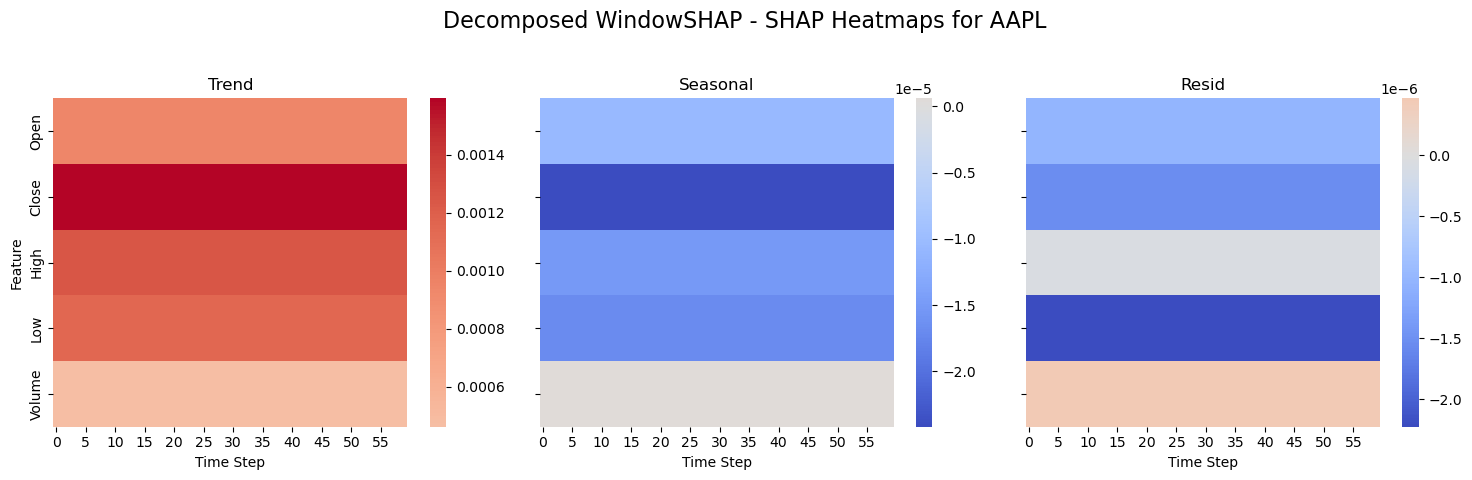

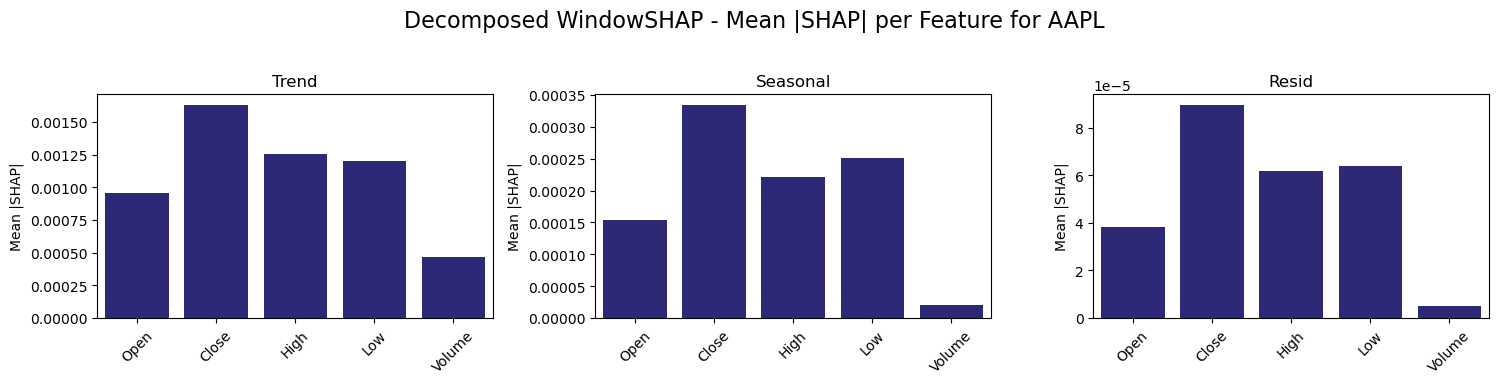

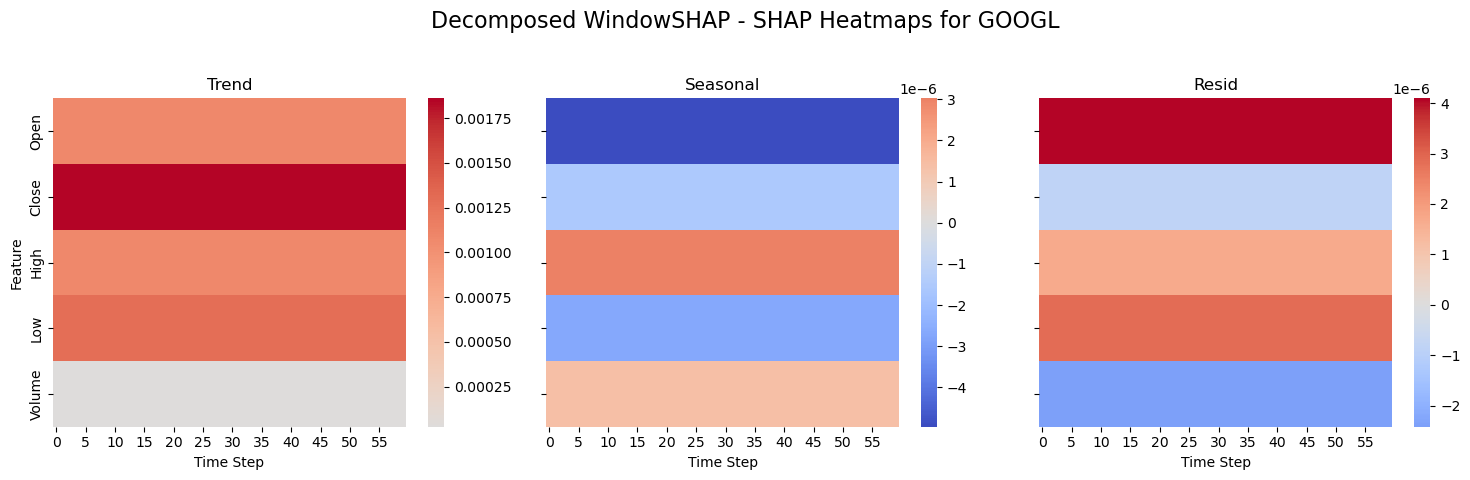

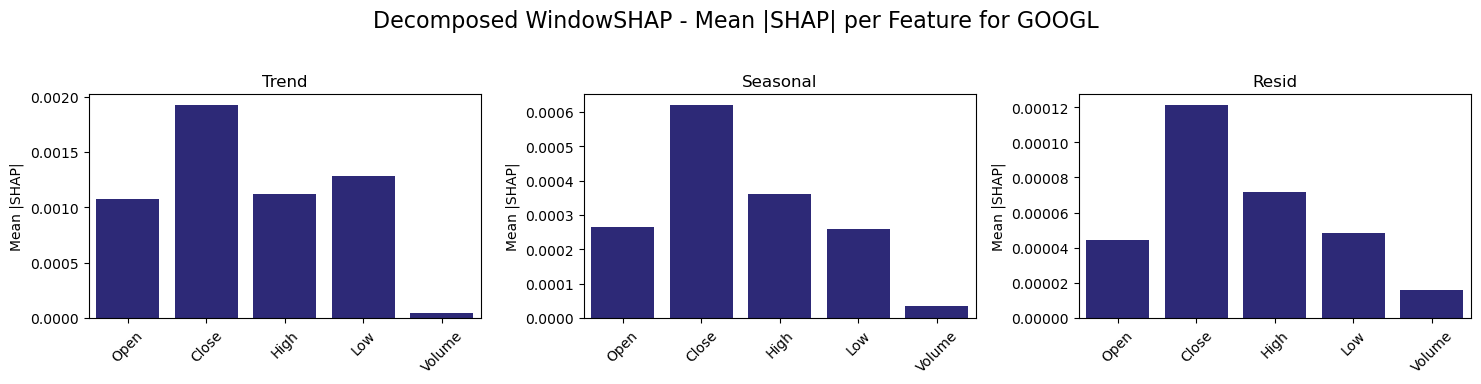

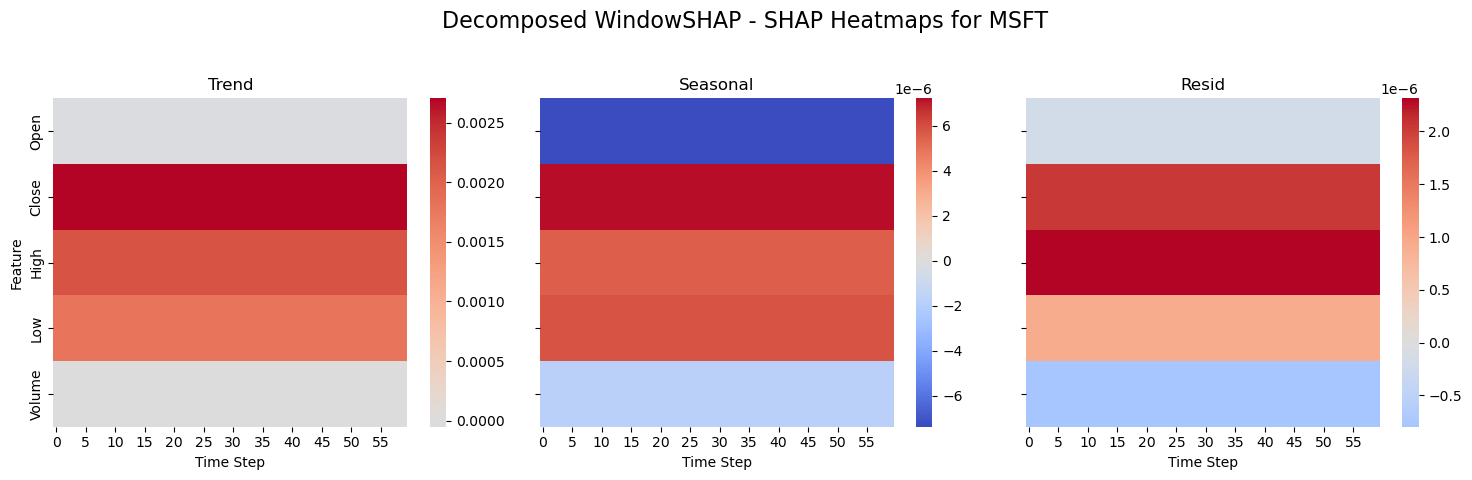

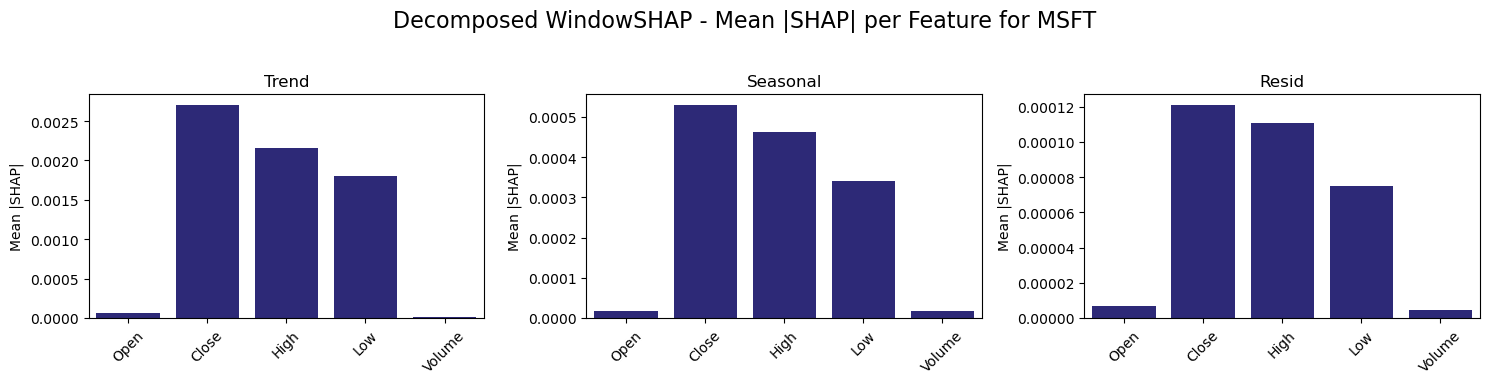

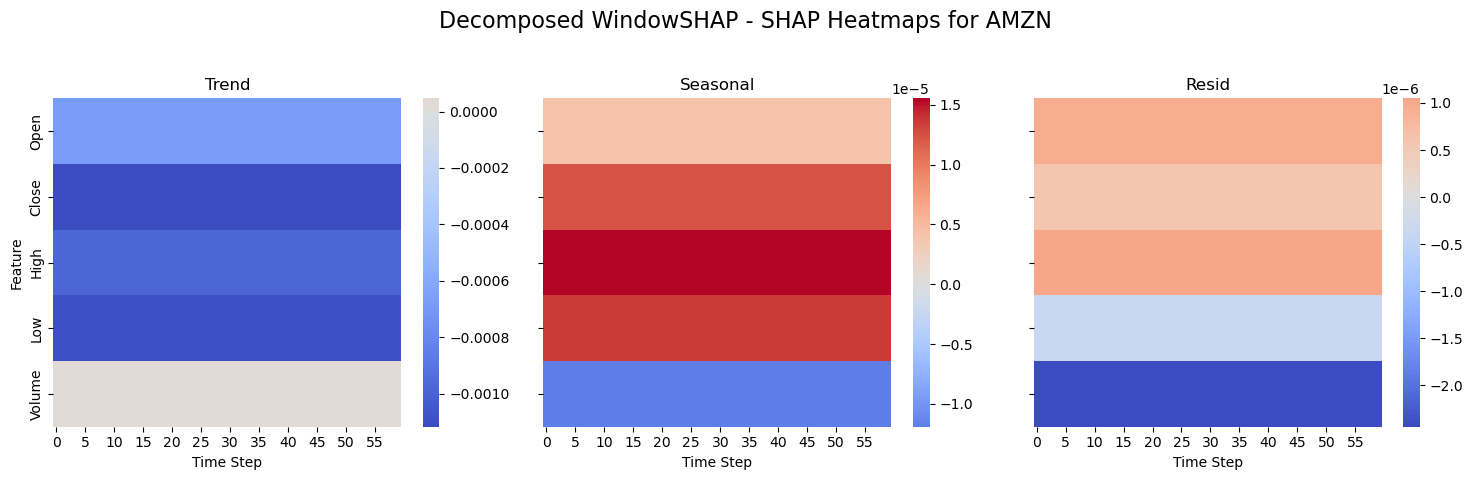

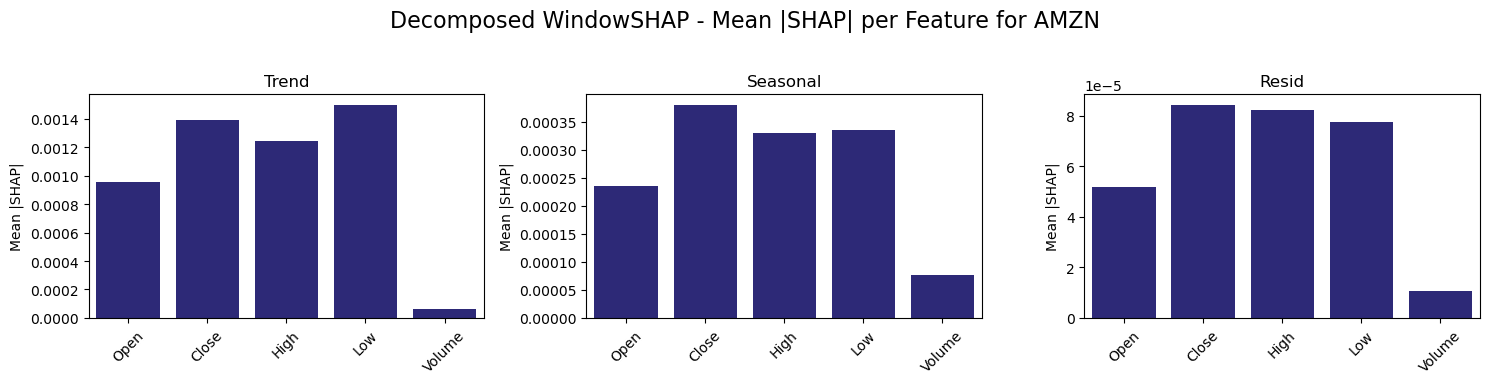

In [ ]:
## Step 4 : Visualize values for each SHAP tool and ticker
shap.initjs()

top_features_per_ticker = {
    ticker: {} for ticker in tickers_list
}

for ticker in tickers_list:
    print(f"\n--- {ticker} ---")

    for tool in shap_tools:
        if tool == 'Decomposed_WindowSHAP':
            component_total_abs_shaps = {}

            fig_heat, axes_heat = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
            fig_heat.suptitle(f'Decomposed WindowSHAP - SHAP Heatmaps for {ticker}', fontsize=16)

            fig_bar, axes_bar = plt.subplots(1, 3, figsize=(15, 4))
            fig_bar.suptitle(f'Decomposed WindowSHAP - Mean |SHAP| per Feature for {ticker}', fontsize=16)

            for i, component in enumerate(shap_per_ticker[ticker][tool].keys()):
                shap_values = shap_per_ticker[ticker][tool][component]
                avg_shap = np.mean(shap_values, axis=0)
                avg_shap = np.squeeze(avg_shap)
                abs_avg_shap = np.mean(np.abs(shap_values), axis=(0, 1))
                abs_avg_shap = np.squeeze(abs_avg_shap)

                component_total_abs_shaps[component] = np.sum(np.abs(shap_values))

                # Heatmap of Average SHAP
                sns.heatmap(
                    avg_shap.T,
                    xticklabels=5,
                    yticklabels=included_features,
                    cmap='coolwarm',
                    center=0,
                    annot=False,
                    ax=axes_heat[i]
                )
                axes_heat[i].set_title(component.capitalize())
                axes_heat[i].set_xlabel("Time Step")
                if i == 0:
                    axes_heat[i].set_ylabel("Feature")

                # Bar Plot of Average SHAP, with abosolute values
                sns.barplot(x=included_features, y=abs_avg_shap, ax=axes_bar[i])
                axes_bar[i].set_title(component.capitalize())
                axes_bar[i].set_ylabel("Mean |SHAP|")
                axes_bar[i].tick_params(axis='x', rotation=45)

            # Find the top component (highest total absolute SHAP value)
            top_component_name = max(component_total_abs_shaps, key=component_total_abs_shaps.get)
            top_decomposed_features = [f"{feat}_{top_component_name}" for feat in included_features]
            top_features_per_ticker[ticker]['Decomposed_WindowSHAP'] = top_decomposed_features
            top_component_shap = component_total_abs_shaps[top_component_name]
            total_shap = sum(component_total_abs_shaps.values())
            top_component_prop = top_component_shap / total_shap * 100.0

            print(f"Top Decomposed WindowSHAP Component for {ticker}: {top_component_name} -- Proportion of output covered: {top_component_prop:.3f} %")

            # Finalize and save plots
            fig_heat.tight_layout(rect=[0, 0.03, 1, 0.95])
            fig_bar.tight_layout(rect=[0, 0.03, 1, 0.95])

            fig_heat.savefig(f"{figure_folder_path}/{ticker}_heatmap_for_{tool}.png")
            fig_bar.savefig(f"{figure_folder_path}/{ticker}_barplot_for_{tool}.png")

        else:

            shap_vals = shap_per_ticker[ticker][tool]
            avg_shap = np.mean(shap_vals, axis=0)
            avg_shap = np.squeeze(avg_shap)
            abs_avg_shap = np.mean(np.abs(shap_vals), axis=(0, 1))
            abs_avg_shap = np.squeeze(abs_avg_shap)
            total_shap = np.sum(abs_avg_shap)

            # Heatmap of Average SHAP Values
            plt.figure(figsize=(10, 5))
            sns.heatmap(
                avg_shap.T,
                xticklabels=5,
                yticklabels=included_features,
                cmap='coolwarm',
                center=0
            )
            plt.title(f'{tool} - Average Values over Time for {ticker}')
            plt.xlabel('Time Step')
            plt.ylabel('Feature')
            plt.tight_layout()
            plt.savefig(f"{figure_folder_path}/{ticker}_heatmap_for_{tool}.png")
            plt.close()

            # Bar Plot of Average SHAP Values, with abosolute values
            plt.figure(figsize=(8, 4))
            sns.barplot(x=included_features, y=abs_avg_shap)
            plt.title(f'{tool} - Mean Absolute Value per Feature for {ticker}')
            plt.ylabel('Mean |SHAP|')
            plt.tight_layout()
            plt.savefig(f"{figure_folder_path}/{ticker}_barplot_for_{tool}.png")
            plt.close()

            # Top 3 features based on mean absolute SHAP values
            top3_idx = np.argsort(-abs_avg_shap)[:3]
            top3_features = [included_features[i] for i in top3_idx]
            top_features_per_ticker[ticker][tool] = top3_features
            top3_shap = np.sum(abs_avg_shap[top3_idx])
            top3_prop = top3_shap / total_shap * 100.0

            print(f"Top {tool} Features for {ticker}: {top3_features} -- Proportion of output covered: {top3_prop:.3f} %")




In [ ]:
tool = 'Decomposed_WindowSHAP' # For the context of this snippet

for ticker in tickers_list: # Assuming 'tickers' list is available
    if tool == 'Decomposed_WindowSHAP':
        # Stores the average SHAP values per window for each component
        avg_shap_per_component_window = []
        # Stores the overall mean absolute SHAP for each component
        overall_mean_abs_shap_per_component = []
        component_names_for_plot = []

        # Prepare figures for plotting
        fig_heat, axes_heat = plt.subplots(1, 1, figsize=(10, 5)) # Single heatmap for components
        fig_heat.suptitle(f'Decomposed WindowSHAP - Average SHAP per Component over Time for {ticker}', fontsize=14)

        fig_bar, axes_bar = plt.subplots(1, 1, figsize=(8, 4)) # Single bar plot for components
        fig_bar.suptitle(f'Decomposed WindowSHAP - Overall Mean |SHAP| per Component for {ticker}', fontsize=14)


        for component_name, shap_values_component_data in shap_per_ticker[ticker][tool].items():
            # shap_values_component_data shape: (num_test_samples, num_windows, num_features)

            # Prep SHAP values for Heatmap
            avg_shap_across_features_and_samples = np.mean(shap_values_component_data, axis=(0, 2))
            avg_shap_per_component_window.append(avg_shap_across_features_and_samples)
            component_names_for_plot.append(component_name.capitalize())

            # Prep SHAP values for Bar Plot
            overall_mean_abs_component = np.mean(np.abs(shap_values_component_data))
            overall_mean_abs_shap_per_component.append(overall_mean_abs_component)

        heatmap_data = np.array(avg_shap_per_component_window)

        # Heatmap of Average SHAP Values
        sns.heatmap(
            heatmap_data,
            xticklabels=np.arange(heatmap_data.shape[1]), # Time step indices
            yticklabels=component_names_for_plot, # 'Trend', 'Seasonal', 'Residual'
            cmap='coolwarm',
            center=0,
            annot=False, # Set to True if you want numbers on the heatmap
            ax=axes_heat
        )
        axes_heat.set_xlabel("Time Step (Window Index)", fontsize=10)
        axes_heat.set_ylabel("Decomposed Component", fontsize=10)


        # Bar Plot of Average SHAP Values, with abosolute values
        sns.barplot(x=component_names_for_plot, y=overall_mean_abs_shap_per_component, ax=axes_bar)
        axes_bar.set_ylabel("Overall Mean |SHAP|", fontsize=10)
        axes_bar.tick_params(axis='x', rotation=45) # Rotate labels for readability

        # Finalize and store figures
        fig_heat.tight_layout(rect=[0, 0.03, 1, 0.95])
        fig_bar.tight_layout(rect=[0, 0.03, 1, 0.95])

        fig_heat.savefig(f"{figure_folder_path}/{ticker}_decomposed_heatmap_components.png")
        fig_bar.savefig(f"{figure_folder_path}/{ticker}_decomposed_barplot_components.png")
        plt.close(fig_heat) # Close figures to free memory
        plt.close(fig_bar)


In [ ]:
### Step 5 : Re-run LSTM using top 3 SHAP features from each tool for each ticker

for tool in shap_tools:
    print(f"\nRe-running LSTM with Top {tool} Features")
    eval_metrics_per_ticker = {}

    for ticker in tickers_list:
        print(f"\nProcessing {ticker}...")
        start_time = time.time()
        process = psutil.Process(os.getpid())
        start_ram = process.memory_info().rss / (1024 * 1024)

        top3_features = top_features_per_ticker[ticker][tool]

        if tool != 'Decomposed_WindowSHAP':
            full_df = data_per_ticker[ticker].df[top3_features] 
            ticker_subset = TickerData(full_df)
            X_train, y_train = ticker_subset.X_train, ticker_subset.y_train
            X_test, y_test = ticker_subset.X_test, ticker_subset.y_test

        else:
            components = ['trend', 'seasonal', 'resid']
            base_feats = included_features

            def get_decomposed_data(ticker, features, dataset_type='train'):
                data_list = []
                for feat_comp in features:

                    base_feat, comp = feat_comp.rsplit('_', 1)

                    if dataset_type == 'train':
                        if comp == 'trend':
                            data_comp = data_per_ticker[ticker].X_train_trend[:, :, base_feats.index(base_feat)]
                        elif comp == 'seasonal':
                            data_comp = data_per_ticker[ticker].X_train_seasonal[:, :, base_feats.index(base_feat)]
                        elif comp == 'resid':
                            data_comp = data_per_ticker[ticker].X_train_residual[:, :, base_feats.index(base_feat)]
                    else:
                        if comp == 'trend':
                            data_comp = data_per_ticker[ticker].X_test_trend[:, :, base_feats.index(base_feat)]
                        elif comp == 'seasonal':
                            data_comp = data_per_ticker[ticker].X_test_seasonal[:, :, base_feats.index(base_feat)]
                        elif comp == 'resid':
                            data_comp = data_per_ticker[ticker].X_test_residual[:, :, base_feats.index(base_feat)]

                    data_list.append(data_comp)

                return np.stack(data_list, axis=2)

            X_train = get_decomposed_data(ticker, top3_features, 'train')
            y_train = data_per_ticker[ticker].y_train
            X_test = get_decomposed_data(ticker, top3_features, 'test')
            y_test = data_per_ticker[ticker].y_test

        model = build_model((n_window_size, X_train.shape[2]))
        model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0)

        inv_y_pred, inv_y_test = gen_store_predictions(model, X_test, y_test, ticker)
        mae, mse, rmse, mape = evaluate_predictions(inv_y_pred, inv_y_test)

        end_time = time.time()
        end_ram = process.memory_info().rss / (1024 * 1024)

        total_time = end_time - start_time
        total_ram = end_ram - start_ram

        memory_usage = process.memory_info().rss / (1024 * 1024)

        r_2 = r2_score(inv_y_test, inv_y_pred)

        model_per_ticker[ticker][tool] = {
        'model': model,
        'runtime': total_time,
        'memory_usage': total_ram,
        'y_pred': inv_y_pred,
        'y_test': inv_y_test,
        'r2' : r_2,
        'metrics': {
            'mae': mae,
            'mse': mse,
            'rmse': rmse,
            'mape': mape
        }}

print('LSTM re-computation complete.')


Re-running LSTM with Top SHAP Features

Processing AAPL...

Processing GOOGL...

Processing MSFT...

Processing AMZN...

Re-running LSTM with Top WindowSHAP Features

Processing AAPL...

Processing GOOGL...

Processing MSFT...

Processing AMZN...

Re-running LSTM with Top Decomposed_WindowSHAP Features

Processing AAPL...

Processing GOOGL...

Processing MSFT...

Processing AMZN...
LSTM re-computation complete.


In [ ]:
### Step 6 : Evaluate and compare results

## Step 6.1 : Compare runtime and RAM usage

for tool in shap_tools:
    print(f'\nLSTM Runtime and RAM Usage for {tool}:\n')

    computation_data = {
        ticker: {
            'runtime': model_per_ticker[ticker][tool]['runtime'],
            'memory_usage': model_per_ticker[ticker][tool]['memory_usage']
        }
        for ticker in model_per_ticker
    }

    computation_df = pd.DataFrame.from_dict(computation_data, orient='index')
    print(computation_df.to_string(float_format='%.3f'))
     


LSTM Runtime and RAM Usage for SHAP:

       runtime  memory_usage
AAPL   65.1810      210.4844
GOOGL  65.4773       -5.4531
MSFT   66.5747        1.3906
AMZN   70.8106       13.1094

LSTM Runtime and RAM Usage for WindowSHAP:

       runtime  memory_usage
AAPL   66.0747       39.8281
GOOGL  65.8403       -3.8906
MSFT   70.3613      -57.5938
AMZN   67.0443       -5.2031

LSTM Runtime and RAM Usage for Decomposed_WindowSHAP:

       runtime  memory_usage
AAPL   67.2742        8.7812
GOOGL  66.3311        3.3594
MSFT   71.3921       25.0625
AMZN   67.8666      -18.7344


In [ ]:
## Step 6.2 : Compute evaluation metrics 

for tool in shap_tools:
    metrics_df = pd.DataFrame({
        ticker: model_per_ticker[ticker][tool]['metrics']
        for ticker in model_per_ticker
    }).T

    metrics_df = metrics_df[['mae', 'mse', 'rmse', 'mape']]

    print(f"\nLSTM Evaluation Metrics -- Based on {tool}:\n")
    print(metrics_df.to_string(float_format='%.3f'))
    metrics_df.to_latex(f"{table_folder_path}/{tool}_eval_metrics.tex", 
               caption=f"Evaluation Metrics for {tool}-based LSTM",
               label=f"tab:{tool.lower()}_summary",
               float_format="%.3f")


LSTM Evaluation Metrics -- Based on SHAP:

          mae      mse    rmse   mape
AAPL   4.6520  45.2238  6.7249 3.3859
GOOGL  4.7318  39.5197  6.2865 4.5072
MSFT  13.6228 343.9342 18.5455 4.9443
AMZN   4.5577  37.2157  6.1005 3.6803

LSTM Evaluation Metrics -- Based on WindowSHAP:

          mae      mse    rmse   mape
AAPL   5.4006  53.4394  7.3102 3.8786
GOOGL  5.0859  43.9471  6.6293 4.8693
MSFT  14.2262 362.6308 19.0429 5.1555
AMZN   4.9245  42.3898  6.5107 4.0247

LSTM Evaluation Metrics -- Based on Decomposed_WindowSHAP:

          mae       mse    rmse    mape
AAPL  10.1017  169.4869 13.0187  7.1594
GOOGL 12.7889  250.3165 15.8214 12.2988
MSFT  26.6208 1077.1593 32.8201  9.0021
AMZN  13.4639  286.2318 16.9184 10.9470


In [ ]:
for ticker in tickers_list:
        plt.figure(figsize=(14, 8))
        plt.plot(data_per_ticker[ticker].y_test, label='Actual Values', color='black') # Matplotlib default blue
        plt.plot(model_per_ticker[ticker]['Standard']['y_pred'], label='Standard LSTM Predictions', color=color_palette[0])
        plt.plot(model_per_ticker[ticker]['SHAP']['y_pred'], label='SHAP LSTM Predictions', color=color_palette[1])
        plt.plot(model_per_ticker[ticker]['WindowSHAP']['y_pred'], label='WindowSHAP LSTM Predictions', color=color_palette[2])
        plt.plot(model_per_ticker[ticker]['Decomposed_WindowSHAP']['y_pred'], label='Decomposed WindowSHAP LSTM Predictions', color=color_palette[3])

        plt.title(f'{ticker} - Actual vs. Predicted Close Prices', fontsize=16)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price', fontsize=12)
        plt.legend(fontsize=10)
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.tight_layout()
        plt.savefig(f"{figure_folder_path}/{ticker}_pred_vs_actual_plot.png")
        plt.close()

print("\nAll requested combined plots have been generated and saved in the 'figures' folder.")


All requested combined plots have been generated and saved in the 'figures' folder.
